In [ ]:
! tar -xvzf data.tar.gz

In [46]:
from glob import glob
import pandas as pd

In [47]:
file_paths = {
  "kpa1": {
      "files": glob("./data/kpa1/*.txt"),
      "pods": "./data/kpa1/monitor/pods_log.txt",
      "nodes": "./data/kpa1/monitor/nodes_log.txt"
  },
  "kpa2": {
      "files": glob("./data/kpa2/*.txt"),
      "pods": "./data/kpa2/monitor/pods_log.txt",
      "nodes": "./data/kpa2/monitor/nodes_log.txt"
  },
  "hpa": {
      "files": glob("./data/hpa/*.txt"),
      "pods": "./data/hpa/monitor/pods_log.txt",
      "nodes": "./data/hpa/monitor/nodes_log.txt"
  },
  
} 

In [48]:
def get_pods_data(file_path):
  df_pods = pd.DataFrame(columns=["timestamp", "n_pods", "avg_cpu", "avg_memory"])
  f = open(file_path, "r")
  counter = 0
  cpu = 0
  memory = 0
  for l in f:
    if l[0] == ">":
      if counter > 0:
        cpu /= counter
        memory /= counter
        df_pods = df_pods.append({"timestamp": timestamp, "n_pods":counter,
                                  "avg_cpu": cpu, "avg_memory": memory}, ignore_index=True)
      timestamp = int(l[1:-1])
      counter = 0
      cpu = 0
      memory = 0
    elif "NAME" in l:
      continue
    else:
      counter += 1
      words = l.split()
      cpu += int(words[1][:-1])
      memory += int(words[2][:-2])
  cpu /= counter
  memory /= counter
  df_pods = df_pods.append({"timestamp": timestamp, "n_pods":counter,
                            "avg_cpu": cpu, "avg_memory": memory}, ignore_index=True)
      
  f.close()
  return df_pods

In [49]:
def get_nodes_data(file_path):
  df_nodes = pd.DataFrame(columns=["timestamp", "avg_cpu", "avg_memory"])
  f = open(file_path, "r")
  counter = 0
  cpu = 0
  memory = 0
  for l in f:
    if l[0] == ">":
      if counter > 0:
        cpu /= counter
        memory /= counter
        df_nodes = df_nodes.append({"timestamp": timestamp,
                                  "avg_cpu": cpu, "avg_memory": memory},
                                  ignore_index=True)
      timestamp = int(l[1:-1])
      counter = 0
      cpu = 0
      memory = 0
    elif "NAME" in l or len(l) == 1:
      continue
    else:
      counter += 1
      words = l.split()
      cpu += int(words[1][:-1])
      memory += int(words[3][:-2])
  cpu /= counter
  memory /= counter
  df_pods = df_nodes.append({"timestamp": timestamp,
                            "avg_cpu": cpu, "avg_memory": memory},
                            ignore_index=True)
      
  f.close()
  return df_nodes

In [50]:
from datetime import datetime

def to_timestamp(s):
  format = "%a %b %d %Y %H:%M:%S %Z%z (Mountain Standard Time)"
  return int(datetime.timestamp(datetime.strptime(s,format)))

In [51]:
import shutil
import os
def fix_file(file_path):
  f1 = open(file_path, "r")
  f2 = open("./tmp.txt", "w")

  for l in f1:
    index = l.rfind("[")
    while index > 0:
      print(l)
      l2 = l[:l[1:].find("[")]
      if "Total time" in l2 and l2[-1].isnumeric():
        l2 += " s"
      f2.write(l2+"\n")
      l = l[l[1:].find("[")+1:]
      index = l.rfind("[")
    f2.write(l)
  f1.close()
  f2.close()
  os.remove(file_path)
  os.rename("./tmp.txt", file_path)  

In [52]:
def parse_loadtest(file_path):
  # fix_file(file_path)
  f = open(file_path, "r")
  timestamp = -1
  n_errors = -1
  total_time = -1
  requests_per_second = -1
  mean_latency = -1
  for l in f:
    date_str = l[1:l.find("]")]
    l = l[l.find("]")+1:]
    if "Total errors" in l:
      n_errors = int(l.split()[-1])
    elif "Total time" in l:
      timestamp = to_timestamp(date_str)
      total_time = float(l.split()[-2])
      if l.split()[-1] != "s" and total_time > 0:
        if l.split()[-1] == "ms":
          total_time = total_time/1000
        else:
          print("Error total time not in seconds but in " + l.split()[-1])
    elif "Requests per second" in l:
      requests_per_second = int(l.split()[-1])
    elif "Mean latency" in l:
      mean_latency = float(l.split()[-2])
      if l.split()[-1] != "ms" and total_time > 0:
        if l.split()[-1] == "s":
          mean_latency = mean_latency*1000
        else:
          print("Error total time not in ms but in " + l.split()[-1])
  f.close()
  return timestamp, n_errors, total_time, requests_per_second, mean_latency

In [53]:
def get_requests_data(loadtest_files):
  df_requests = pd.DataFrame(columns=["step", "HashApp", "timestamp", "errors",
                                      "total_time", "rps", "mean_latency"])
  for lf in loadtest_files:
    # print(lf)
    timestamp, n_errors, total_time, requests_per_second, mean_latency = parse_loadtest(lf)
    words = lf[lf.rfind("/")+1:].split("_")
    step = int(words[0])
    hash_app = words[1][:-4]
    df_requests = df_requests.append({
        "step": step,
        "HashApp": hash_app,
        "timestamp": timestamp,
        "errors": n_errors,
        "total_time": total_time,
        "rps": requests_per_second,
        "mean_latency": mean_latency
    }, ignore_index=True)
  return df_requests

In [59]:
df_kpa1_pods = get_pods_data(file_paths["kpa1"]["pods"])
df_kpa2_pods = get_pods_data(file_paths["kpa2"]["pods"])
df_hpa_pods = get_pods_data(file_paths["hpa"]["pods"])

In [60]:
df_kpa1_nodes = get_nodes_data(file_paths["kpa1"]["nodes"])
df_kpa2_nodes = get_nodes_data(file_paths["kpa2"]["nodes"])
df_hpa_nodes = get_nodes_data(file_paths["hpa"]["nodes"])

In [62]:
# df_kpa1_requests = get_requests_data(file_paths["kpa1"]["files"])
df_kpa2_requests = get_requests_data(file_paths["kpa2"]["files"])
df_hpa_requests = get_requests_data(file_paths["hpa"]["files"])

In [ ]:
traces = pd.read_csv("traces.csv")

In [63]:
df_kpa2_requests

,step,HashApp,timestamp,errors,total_time,rps,mean_latency
0,513,1ac4f7db351d94666ba3937835f0a6842174b506e0e370...,1615665887,2,0.439826,5,304.6
1,747,0adab8a8e64926f7bd9f3de32fa94406721b01170e4534...,1615666161,1,0.030718,33,28.2
2,1332,8b0135d8bb66b0e165e439e02893fe9c166163d594252f...,1615666826,0,0.082749,97,54.4
3,1051,5a549eca119933f4c1fd6828baa946cdf45a72e21dfb0d...,1615666512,1,0.036904,27,34.1
4,412,3f9fb0df8cc1017c171a7f07afd0fd8ca810f9a6f422a0...,1615665732,7,1.320359,6,766.9
...,...,...,...,...,...,...,...
14740,175,021e53f3b7593b9e400b25a13e037a638c299884db3514...,1615665402,2,0.115830,17,79.0
14741,583,ed41bf82dc3ad660ebde799fa9a845e193bd32584d895f...,1615665982,1,0.107378,9,104.7
14742,179,4c34c02803614b18d4181a0ea3ff83c76c08d559bda561...,1615665408,1,0.075512,13,72.8
14743,28,9b23e981f8a2d32d6b75f6f81c3499bf5a2b84c7c592eb...,1615665239,0,0.048649,62,37.7


In [65]:
df_hpa_requests

,step,HashApp,timestamp,errors,total_time,rps,mean_latency
0,513,1ac4f7db351d94666ba3937835f0a6842174b506e0e370...,1615337687,2,0.508526,4,393.7
1,747,0adab8a8e64926f7bd9f3de32fa94406721b01170e4534...,1615337974,1,0.038563,26,35.4
2,1332,8b0135d8bb66b0e165e439e02893fe9c166163d594252f...,1615338664,8,0.084854,94,61.1
3,1051,5a549eca119933f4c1fd6828baa946cdf45a72e21dfb0d...,1615338341,1,0.031436,32,28.9
4,412,3f9fb0df8cc1017c171a7f07afd0fd8ca810f9a6f422a0...,1615337523,7,1.608243,5,981.4
...,...,...,...,...,...,...,...
14740,175,021e53f3b7593b9e400b25a13e037a638c299884db3514...,1615337181,2,0.163167,12,103.9
14741,583,ed41bf82dc3ad660ebde799fa9a845e193bd32584d895f...,1615337786,1,0.146442,7,143.9
14742,179,4c34c02803614b18d4181a0ea3ff83c76c08d559bda561...,1615337186,1,0.097874,10,95.1
14743,28,9b23e981f8a2d32d6b75f6f81c3499bf5a2b84c7c592eb...,1615337017,0,0.060539,50,47.2


In [ ]:
import matplotlib.pyplot as plt 


# x1 = df["time_step"] 
# y1 = df["kpa1_n_pods"]  
# plt.plot(x1, y1, label = "KPA 1") 
  
x2 = df["time_step"] 
y2 = df["total_requests"]  
plt.plot(x2, y2, label = "No. of requests") 

x3 = df["time_step"] 
y3 = df["total_memory_requested"]  
plt.plot(x3, y3, label = "Memory Requested") 

y4 = df["total_duration_requested"]  
plt.plot(x1, y4, label = "Duration Requested") 
  
plt.xlabel('Time stamp') 
# plt.ylabel('Metrics') 
plt.title('Total Metrics') 
  
plt.legend() 
plt.show() 

In [115]:
df = pd.read_csv("knative_benchmark_dataset.csv")
df

,time_step,total_requests,total_memory_requested,total_duration_requested,kpa1_n_pods,kpa1_pods_avg_cpu,kpa1_pods_avg_memory,kpa1_errors,kpa2_n_pods,kpa2_pods_avg_cpu,kpa2_pods_avg_memory,kpa2_errors,hpa_n_pods,hpa_pods_avg_cpu,hpa_pods_avg_memory,hpa_errors
0,1,223,2489,123,1.0,8.000000,50.000000,193,1.0,13.000000,42.000000,193,1.0,9.0,40.0,193
1,2,209,1417,22,1.0,8.000000,50.000000,179,1.0,13.000000,42.000000,179,1.0,9.0,40.0,179
2,3,219,1783,25,1.0,8.000000,50.000000,185,1.0,13.000000,42.000000,185,1.0,9.0,40.0,185
3,4,183,1897,95,1.0,8.000000,50.000000,155,1.0,13.000000,42.000000,155,1.0,9.0,40.0,155
4,5,182,1490,83,1.0,8.000000,50.000000,159,1.0,13.000000,42.000000,159,1.0,9.0,40.0,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1436,826,2461,121,217.0,17.829493,63.041475,824,232.0,13.232759,63.474138,804,1.0,2430.0,6083.0,819
1436,1437,903,1518,91,217.0,17.829493,63.041475,903,226.0,13.557522,64.243363,903,1.0,2430.0,6083.0,903
1437,1438,1547,1524,21,217.0,17.829493,63.041475,1547,219.0,13.958904,65.319635,1529,1.0,2430.0,6083.0,1547
1438,1439,1316,1632,92,217.0,13.142857,65.525346,1278,217.0,14.078341,65.433180,1316,1.0,2430.0,6083.0,1316


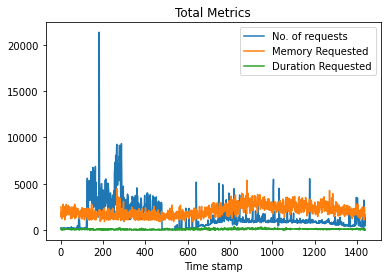

In [107]:
import matplotlib.pyplot as plt 


# x1 = df["time_step"] 
# y1 = df["kpa1_n_pods"]  
# plt.plot(x1, y1, label = "KPA 1") 
  
x2 = df["time_step"] 
y2 = df["total_requests"]  
plt.plot(x2, y2, label = "No. of requests") 

x3 = df["time_step"] 
y3 = df["total_memory_requested"]  
plt.plot(x3, y3, label = "Memory Requested") 

y4 = df["total_duration_requested"]  
plt.plot(x1, y4, label = "Duration Requested") 
  
plt.xlabel('Time stamp') 
# plt.ylabel('Metrics') 
plt.title('Total Metrics') 
  
plt.legend() 
plt.show() 

# time_step	total_requests	total_memory_requested	total_duration_requested	
# kpa1_n_pods	kpa1_pods_avg_cpu	kpa1_pods_avg_memory	kpa1_errors	
# kpa2_n_pods	kpa2_pods_avg_cpu	kpa2_pods_avg_memory	kpa2_errors	
# hpa_n_pods hpa_pods_avg_cpu	hpa_pods_avg_memory	hpa_errors

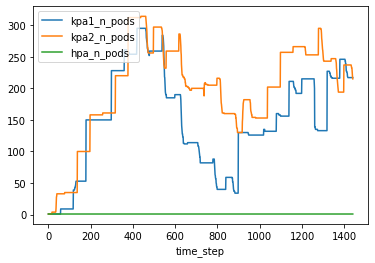

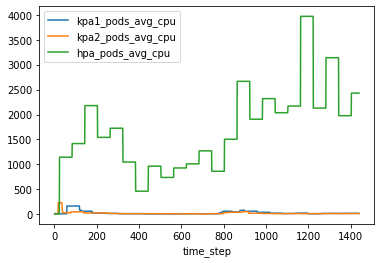

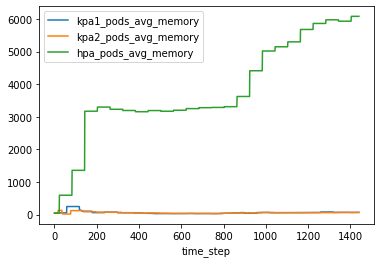

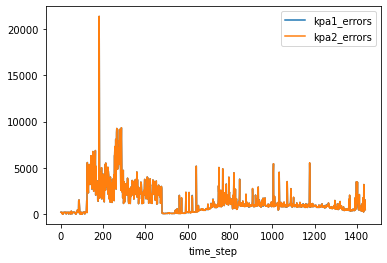

In [118]:
# df.set_index("time_step", inplace=True)
df[["kpa1_n_pods", "kpa2_n_pods", "hpa_n_pods"]].plot()
df[["kpa1_pods_avg_cpu", "kpa2_pods_avg_cpu", "hpa_pods_avg_cpu"]].plot()
df[["kpa1_pods_avg_memory", "kpa2_pods_avg_memory", "hpa_pods_avg_memory"]].plot()
df[["kpa1_errors", "kpa2_errors" ]].plot()

In [109]:
df1 = pd.read_csv("app1.csv")
df1

,time_step,kpa1_n_requests,kpa1_errors,kpa1_total_time,kpa1_mean_latency,kpa2_n_requests,kpa2_errors,kpa2_total_time,kpa2_mean_latency,hpa_n_requests,hpa_errors,hpa_total_time,hpa_mean_latency
0,1,8,0,0.084130,56.4,8,0,0.109373,59.9,8,0,0.083246,57.6
1,2,8,0,0.125593,87.9,8,0,0.066888,42.5,8,0,0.087420,58.7
2,3,8,0,0.074048,40.6,8,0,0.077434,51.5,8,0,0.086601,59.5
3,4,8,0,0.072535,49.6,8,0,0.113022,75.1,8,0,0.079414,54.1
4,5,8,0,0.066976,39.5,8,0,0.070867,42.8,8,0,0.064747,38.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1436,8,8,0.088671,59.6,8,6,0.150738,89.9,8,8,0.142399,115.4
1436,1437,8,8,0.094920,73.3,8,8,0.083436,63.1,8,8,0.106238,84.7
1437,1438,8,8,0.111139,89.4,8,2,0.087729,56.9,8,8,0.132390,101.7
1438,1439,8,0,0.154950,102.6,8,8,0.094856,74.0,8,8,0.124533,102.4


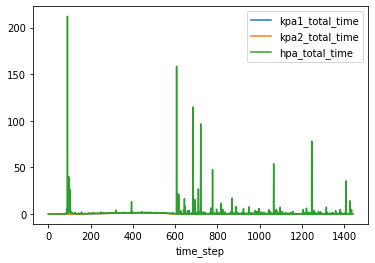

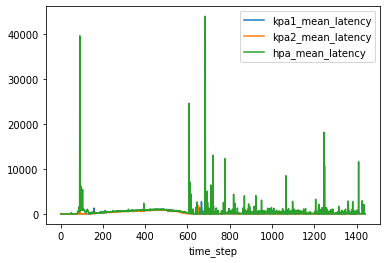

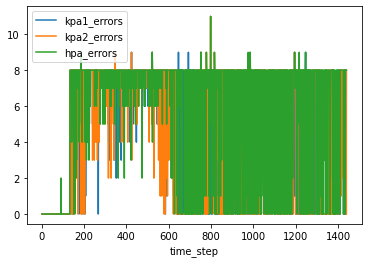

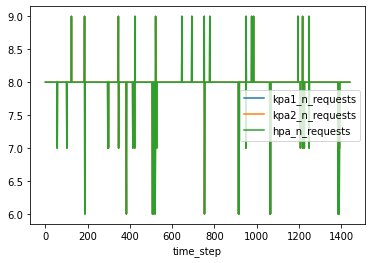

In [111]:
df1.set_index("time_step", inplace=True)
df1[["kpa1_total_time", "kpa2_total_time", "hpa_total_time"]].plot()
df1[["kpa1_mean_latency", "kpa2_mean_latency", "hpa_mean_latency"]].plot()
df1[["kpa1_errors", "kpa2_errors", "hpa_errors"]].plot()
df1[["kpa1_n_requests", "kpa2_n_requests", "hpa_n_requests"]].plot()

In [113]:
df2 = pd.read_csv("app2.csv")
df2

,time_step,kpa1_n_requests,kpa1_errors,kpa1_total_time,kpa1_mean_latency,kpa2_n_requests,kpa2_errors,kpa2_total_time,kpa2_mean_latency,hpa_n_requests,hpa_errors,hpa_total_time,hpa_mean_latency
0,1,1,0,0.078307,74.9,1,0,0.075561,72.5,1,0,0.069754,66.5
1,2,1,0,0.098865,95.9,1,0,0.061233,57.6,1,0,0.060560,58.0
2,3,0,0,0.058458,56.5,0,0,0.058033,55.7,0,0,0.070366,67.7
3,4,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0
4,5,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1436,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0
1436,1437,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0
1437,1438,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0
1438,1439,0,0,0.000000,0.0,0,0,0.000000,0.0,0,0,0.000000,0.0


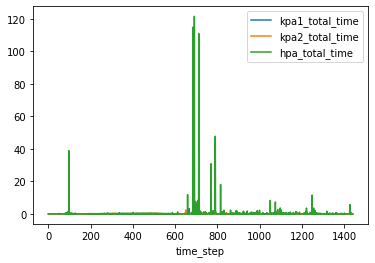

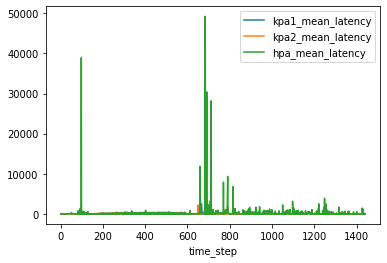

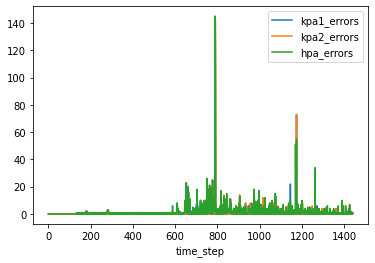

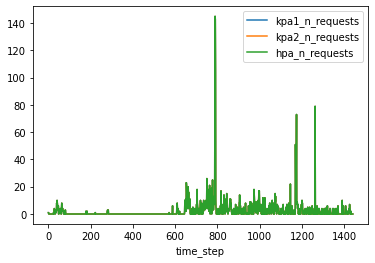

In [114]:
df2.set_index("time_step", inplace=True)
df2[["kpa1_total_time", "kpa2_total_time", "hpa_total_time"]].plot()
df2[["kpa1_mean_latency", "kpa2_mean_latency", "hpa_mean_latency"]].plot()
df2[["kpa1_errors", "kpa2_errors", "hpa_errors"]].plot()
df2[["kpa1_n_requests", "kpa2_n_requests", "hpa_n_requests"]].plot()